## Get data after preprocessing

We use **Kaggle** flatform to run this notebook.

Import **libri-speech-noise-dataset"** to **/kaggle/input/** before running code.

In [1]:
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 58.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.7 MB/s eta 0:00:00


In [2]:
import py7zr

def extract_7z(file_path, output_path):
    with py7zr.SevenZipFile(file_path, mode='r') as z:
        z.extractall(output_path)

extract_7z("/kaggle/input/libri-speech-noise-dataset/noisesB.7z", '/kaggle/working/')
extract_7z("/kaggle/input/libri-speech-noise-dataset/y_train.7z", '/kaggle/working/')
extract_7z("/kaggle/input/libri-speech-noise-dataset/test.7z", '/kaggle/working/')
extract_7z("/kaggle/input/libri-speech-noise-dataset/y_test.7z", '/kaggle/working/')

In [3]:
!git clone https://github.com/bdbao/AI-Noise-Reduction-in-Speech
%cd /kaggle/working/AI-Noise-Reduction-in-Speech

Cloning into 'AI-Noise-Reduction-in-Speech'...
remote: Enumerating objects: 355, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 355 (delta 2), reused 90 (delta 2), pack-reused 263
Receiving objects: 100% (355/355), 150.28 MiB | 38.67 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (320/320), done.
/kaggle/working/AI-Noise-Reduction-in-Speech


In [4]:
import librosa
import numpy as np
import os


def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    """This function take an audio and split into several frame
       in a numpy matrix of size (nb_frame,frame_length)"""

    sequence_sample_length = sound_data.shape[0]

    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]  # get sliding windows
    sound_data_array = np.vstack(sound_data_list)

    return sound_data_array


def audio_files_to_numpy(audio_dir, list_audio_files, sample_rate, frame_length, hop_length_frame, min_duration):
    """This function take audio files of a directory and merge them
    in a numpy matrix of size (nb_frame,frame_length) for a sliding window of size hop_length_frame"""

    list_sound_array = []

    for file in list_audio_files:
        # open the audio file
        y, sr = librosa.load(os.path.join(audio_dir, file), sr=sample_rate)
        total_duration = librosa.get_duration(y=y, sr=sr)

        if (total_duration >= min_duration):
            list_sound_array.append(audio_to_audio_frame_stack(
                y, frame_length, hop_length_frame))
        else:
            print(
                f"The following file {os.path.join(audio_dir,file)} is below the min duration")

    return np.vstack(list_sound_array)


def blend_noise_randomly(voice, noise, nb_samples, frame_length):
    """This function takes as input numpy arrays representing frames
    of voice sounds, noise sounds and the number of frames to be created
    and return numpy arrays with voice randomly blend with noise"""

    prod_voice = np.zeros((nb_samples, frame_length))
    prod_noise = np.zeros((nb_samples, frame_length))
    prod_noisy_voice = np.zeros((nb_samples, frame_length))

    for i in range(nb_samples):
        id_voice = np.random.randint(0, voice.shape[0])
        id_noise = np.random.randint(0, noise.shape[0])
        level_noise = np.random.uniform(0.2, 0.8)
        prod_voice[i, :] = voice[id_voice, :]
        prod_noise[i, :] = level_noise * noise[id_noise, :]
        prod_noisy_voice[i, :] = prod_voice[i, :] + prod_noise[i, :]

    return prod_voice, prod_noise, prod_noisy_voice


def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    """This function takes an audio and convert into spectrogram,
       it returns the magnitude in dB and the phase"""

    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase


def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    """This function takes as input a numpy audi of size (nb_frame,frame_length), and return
    a numpy containing the matrix spectrogram for amplitude in dB and phase. It will have the size
    (nb_frame,dim_square_spec,dim_square_spec)"""

    nb_audio = numpy_audio.shape[0]

    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase


def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
    """This functions reverts a spectrogram to an audio"""

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct

def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :
    """This functions reverts the matrix spectrograms to numpy audio"""

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec

def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec

def inv_scaled_in(matrix_spec):
    "inverse global scaling apply to noisy voices spectrograms"
    matrix_spec = matrix_spec * 50 - 46
    return matrix_spec

def inv_scaled_ou(matrix_spec):
    "inverse global scaling apply to noise models spectrograms"
    matrix_spec = matrix_spec * 82 + 6
    return matrix_spec

## Prepare data for training

In [5]:
!mkdir '/kaggle/working/save_time_serie'
!mkdir '/kaggle/working/save_sound'
!mkdir '/kaggle/working/save_spectrogram'

In [6]:
import os
import librosa
import numpy as np
import soundfile as sf


def create_data(noise_dir, voice_dir, path_save_time_serie, path_save_sound, path_save_spectrogram, sample_rate,
min_duration, frame_length, hop_length_frame, hop_length_frame_noise, nb_samples, n_fft, hop_length_fft):
    """
        This function will randomly blend some clean voices from voice_dir with some noises from noise_dir
        and save the spectrograms of noisy voice, noise and clean voices to disk as well as complex phase,
        time series and sounds. This aims at preparing datasets for denoising training. It takes as inputs
        parameters defined in args module
    """

    list_noise_files = os.listdir(noise_dir)
    list_voice_files = os.listdir(voice_dir)

    def remove_ds_store(lst):
        """remove mac specific file if present"""
        if '.DS_Store' in lst:
            lst.remove('.DS_Store')

        return lst

    list_noise_files = remove_ds_store(list_noise_files)
    list_voice_files = remove_ds_store(list_voice_files)

    nb_voice_files = len(list_voice_files)
    nb_noise_files = len(list_noise_files)


    # Extracting noise and voice from folder and convert to numpy
    noise = audio_files_to_numpy(noise_dir, list_noise_files, sample_rate,
                                     frame_length, hop_length_frame_noise, min_duration)

    voice = audio_files_to_numpy(voice_dir, list_voice_files,
                                     sample_rate, frame_length, hop_length_frame, min_duration)

    # Blend some clean voices with random selected noises (and a random level of noise)
    prod_voice, prod_noise, prod_noisy_voice = blend_noise_randomly(
            voice, noise, nb_samples, frame_length)

    # To save the long audio generated to disk to QC:
    noisy_voice_long = prod_noisy_voice.reshape(1, nb_samples * frame_length)
    sf.write(path_save_sound + 'noisy_voice_long.wav', noisy_voice_long[0, :], sample_rate)
    voice_long = prod_voice.reshape(1, nb_samples * frame_length)
    sf.write(path_save_sound + 'voice_long.wav', voice_long[0, :], sample_rate)
    noise_long = prod_noise.reshape(1, nb_samples * frame_length)
    sf.write(path_save_sound + 'noise_long.wav', noise_long[0, :], sample_rate)

    # Squared spectrogram dimensions
    dim_square_spec = int(n_fft / 2) + 1

    # Create Amplitude and phase of the sounds
    m_amp_db_voice,  m_pha_voice = numpy_audio_to_matrix_spectrogram(
            prod_voice, dim_square_spec, n_fft, hop_length_fft)
    m_amp_db_noise,  m_pha_noise = numpy_audio_to_matrix_spectrogram(
            prod_noise, dim_square_spec, n_fft, hop_length_fft)
    m_amp_db_noisy_voice,  m_pha_noisy_voice = numpy_audio_to_matrix_spectrogram(
            prod_noisy_voice, dim_square_spec, n_fft, hop_length_fft)

    # Save for Training / QC
    np.save(path_save_time_serie + 'voice_timeserie', prod_voice)
    np.save(path_save_time_serie + 'noise_timeserie', prod_noise)
    np.save(path_save_time_serie + 'noisy_voice_timeserie', prod_noisy_voice)


    np.save(path_save_spectrogram + 'voice_amp_db', m_amp_db_voice)
    np.save(path_save_spectrogram + 'noise_amp_db', m_amp_db_noise)
    np.save(path_save_spectrogram + 'noisy_voice_amp_db', m_amp_db_noisy_voice)

    np.save(path_save_spectrogram + 'voice_pha_db', m_pha_voice)
    np.save(path_save_spectrogram + 'noise_pha_db', m_pha_noise)
    np.save(path_save_spectrogram + 'noisy_voice_pha_db', m_pha_noisy_voice)

In [7]:
# folder containing noises
noise_dir = '/kaggle/working/noisesB'
# folder containing clean voices
voice_dir = '/kaggle/working/y_train'
# path to save time series
path_save_time_serie = '/kaggle/working/save_time_serie/'
# path to save sounds
path_save_sound = '/kaggle/working/save_sound/'
# path to save spectrograms
path_save_spectrogram = '/kaggle/working/save_spectrogram/'
# Sample rate to read audio
sample_rate = 8000
# Minimum duration of audio files to consider
min_duration = 1.0
# Frame length for training data
frame_length = 8064
# hop length for clean voice files
hop_length_frame = 8064
# hop length for noise files
hop_length_frame_noise = 5000
# How much frame to create for training
nb_samples = 10000
# nb of points for fft(for spectrogram computation)
n_fft = 255
# hop length for fft
hop_length_fft = 63

In [8]:
create_data(noise_dir, voice_dir, path_save_time_serie, path_save_sound, path_save_spectrogram, sample_rate, min_duration, frame_length, hop_length_frame, hop_length_frame_noise, nb_samples, n_fft, hop_length_fft)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
X_in = np.load(path_save_spectrogram + 'noisy_voice_amp_db' + ".npy")
X_ou = np.load(path_save_spectrogram + 'voice_amp_db' + ".npy")
X_noise = np.load(path_save_spectrogram + 'noise_amp_db' + ".npy")

print(X_in.shape, X_ou.shape, X_noise.shape)

(10000, 128, 128) (10000, 128, 128) (10000, 128, 128)


## Train model

### Define model architecture

In [10]:
!mkdir '/kaggle/working/weights_folder'

In [14]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf

#Unet network
def unet(pretrained_weights = None, input_size = (128,128,1)):
    # size filter input
    size_filter_in = 16
    # normal initialization of weights
    kernel_init = 'he_normal'
    # To apply leaky relu after the conv layer 
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)
    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)
    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mae'])

    # model.summary()

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

print("Define model successfully!")

Define model successfully!


### Training phase

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def training(path_save_spectrogram, weights_path, name_model, training_from_scratch, epochs, batch_size):
    """ 
        This function will read noisy voice and clean voice spectrograms created by data_creation mode,
        and train a Unet model on this dataset for epochs and batch_size specified. It saves best models to disk regularly
        If training_from_scratch is set to True it will train from scratch, if set to False, it will train
        from weights (name_model) provided in weights_path
    """
    
    # load noisy voice & clean voice spectrograms created by data_creation mode
    X_in = np.load(path_save_spectrogram + 'noisy_voice_amp_db' + ".npy")
    X_ou = np.load(path_save_spectrogram + 'voice_amp_db' + ".npy")
    # Model of noise to predict
    X_ou = X_in - X_ou

    #to scale between -1 and 1
    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    # Reshape for training
    X_in = X_in[:,:,:]
    X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    X_ou = X_ou[:,:,:]
    X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)

    X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)

    # If training from scratch
    if training_from_scratch:

        generator_nn=unet()
    else: # If training from pre-trained weights
        generator_nn=unet(pretrained_weights = weights_path + name_model + '.h5')


    # Save best models to disk during training
    checkpoint = ModelCheckpoint(weights_path + '/' + name_model + '.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    early_stopping =tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=4,
        mode="auto",
        restore_best_weights=True,
    )

    generator_nn.summary()
    
    # Training
    history = generator_nn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, checkpoint], verbose=1, validation_data=(X_test, y_test))

    # Plot training and validation loss (log scale)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='Loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training process')
    plt.legend()
    plt.show()
    
    # Save model weights
    model_json = generator_nn.to_json()
    with open("/kaggle/working/weights_folder/model_unet.json", "w") as json_file:
        json_file.write(model_json)
    generator_nn.save_weights("/kaggle/working/weights_folder/model_unet.h5")
    print("Saved model successfully!")
    
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.12.0


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 128, 128, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_23 (LeakyReLU)     (None, 128, 128, 16  0           ['conv2d_24[0][0]']              
                                )                                                           

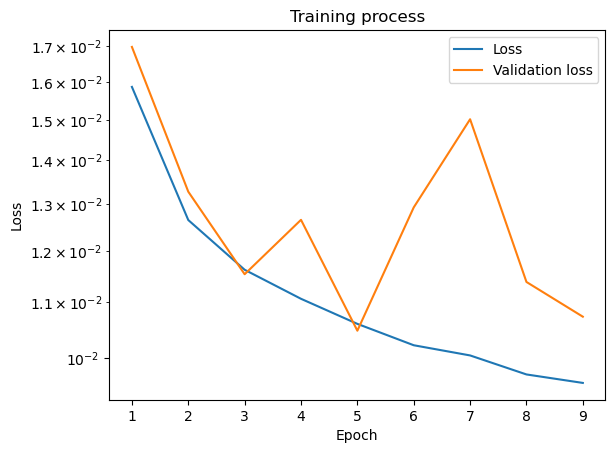

Saved model successfully!


In [16]:
# Path were to read spectrograms of noisy voice and clean voice
path_save_spectrogram = '/kaggle/working/save_spectrogram/'
# path to find pre-trained weights / save models
weights_path = '/kaggle/working/weights_folder/'
# pre trained model
name_model = 'model_unet'
# Training from scratch vs training from pre-trained weights
training_from_scratch = True
# epochs for training
epochs = 10
# batch size for training
batch_size = 16

training(path_save_spectrogram, weights_path, name_model, training_from_scratch, epochs, batch_size)

## Predict speech denoising

In [17]:
!mkdir '/kaggle/working/output_denoised'

In [18]:
import librosa
import tensorflow as tf
from tensorflow.keras.models import model_from_json
import soundfile as sf


def prediction(audio_dir_prediction, audio_input_prediction, audio_output_prediction):
    # Extracting noise and voice from folder and convert to numpy
    audio = audio_files_to_numpy(audio_dir_prediction, audio_input_prediction, sample_rate,
                                 frame_length, hop_length_frame, min_duration)

    #Dimensions of squared spectrogram
    dim_square_spec = int(n_fft / 2) + 1

    # Create Amplitude and phase of the sounds
    m_amp_db_audio,  m_pha_audio = numpy_audio_to_matrix_spectrogram(
        audio, dim_square_spec, n_fft, hop_length_fft)

    # Global scaling to have distribution -1/1
    X_in = scaled_in(m_amp_db_audio)
    # Reshape for prediction
    X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    # Prediction using loaded network
    X_pred = loaded_model.predict(X_in)
    # Rescale back the noise model
    inv_sca_X_pred = inv_scaled_ou(X_pred)
    # Remove noise model from noisy speech
    X_denoise = m_amp_db_audio - inv_sca_X_pred[:,:,:,0]
    # Reconstruct audio from denoised spectrogram and phase
    audio_denoise_recons = matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_audio, frame_length, hop_length_fft)
    # Number of frames
    nb_samples = audio_denoise_recons.shape[0]
    
    # Save all frames in one file
    denoise_long = audio_denoise_recons.reshape(1, nb_samples * frame_length)*10
    sf.write(audio_output_prediction, denoise_long[0, :], sample_rate)

In [19]:
weights_path = './weights'
name_model = 'model_unet'
sample_rate = 8000
min_duration = 1.0      # Minimum duration of audio files to consider
frame_length = 8064     # Our training data will be frame of slightly above 1 second
hop_length_frame = 8064 # Hop length for clean voice files separation (no overlap)
n_fft = 255             # Choosing n_fft and hop_length_fft to have squared spectrograms
hop_length_fft = 63

# Load model
json_file = open(weights_path + '/' + name_model + '.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# Load weights into new model
loaded_model.load_weights(weights_path + '/' + name_model +'.h5')

'''
loaded_model = tf.keras.models.load_model('./weights/model_unet.h5')
'''

print("Load model. Done!")

Load model. Done!


### With arbitrary uploaded audio

In [20]:
audio_dir_prediction = '/kaggle/working/test'
audio_input_prediction = ['730-358-0037.wav']
audio_output_prediction = '/kaggle/working/output_denoised/output.wav'

prediction(audio_dir_prediction, audio_input_prediction, audio_output_prediction)

1/1 [==============================] - 1s 999ms/step


In [21]:
from IPython.display import Audio
display(Audio(audio_dir_prediction + '/' + audio_input_prediction[0]))
display(Audio(audio_output_prediction))

## Some visualizations

In [22]:
import matplotlib.pyplot as plt
import librosa.display

def make_plot_spectrogram(stftaudio_magnitude_db,sample_rate, hop_length_fft) :
    """This function plots a spectrogram"""
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(stftaudio_magnitude_db, x_axis='time', y_axis='linear',
                             sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    title = 'hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
    plt.title(title.format(hop_length_fft,
                           stftaudio_magnitude_db.shape[1],
                           stftaudio_magnitude_db.shape[0],
                           stftaudio_magnitude_db.shape));
    return

def make_plot_phase(stft_phase,sample_rate,hop_length_fft) :
    """This function plots the phase in radian"""
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(np.angle(stft_phase), x_axis='time', y_axis='linear',
                             sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    title = 'hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
    plt.title(title.format(hop_length_fft,
                           stft_phase.shape[1],
                           stft_phase.shape[0],
                           stft_phase.shape));
    return

def make_plot_time_serie(audio,sample_rate):
    """This function plots the audio as a time serie"""
    plt.figure(figsize=(12, 6))
    #plt.ylim(-0.05, 0.05)
    plt.title('Audio')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    librosa.display.waveshow(audio, sr=sample_rate)
    return


def make_3plots_spec_voice_noise(stftvoicenoise_mag_db,stftnoise_mag_db,stftvoice_mag_db,sample_rate, hop_length_fft):
    """This function plots the spectrograms of noisy voice, noise and voice as a single plot """
    plt.figure(figsize=(8, 12))
    plt.subplot(3, 1, 1)
    plt.title('Spectrogram voice + noise')
    librosa.display.specshow(stftvoicenoise_mag_db, x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.subplot(3, 1, 2)
    plt.title('Spectrogram predicted voice')
    librosa.display.specshow(stftnoise_mag_db, x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.subplot(3, 1, 3)
    plt.title('Spectrogram true voice')
    librosa.display.specshow(stftvoice_mag_db, x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.tight_layout()

    return


def make_3plots_phase_voice_noise(stftvoicenoise_phase,stftnoise_phase,stftvoice_phase,sample_rate, hop_length_fft):
    """This function plots the phase in radians of noisy voice, noise and voice as a single plot """
    plt.figure(figsize=(8, 12))
    plt.subplot(3, 1, 1)
    plt.title('Phase (radian) voice + noise')
    librosa.display.specshow(np.angle(stftvoicenoise_phase), x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.subplot(3, 1, 2)
    plt.title('Phase (radian) predicted voice')
    librosa.display.specshow(np.angle(stftnoise_phase), x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.subplot(3, 1, 3)
    plt.title('Phase (radian) true voice')
    librosa.display.specshow(np.angle(stftvoice_phase), x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.tight_layout()

    return


def make_3plots_timeseries_voice_noise(clipvoicenoise,clipnoise,clipvoice, sample_rate) :
    """This function plots the time series of audio of noisy voice, noise and voice as a single plot """
    #y_ax_min = min(clipvoicenoise) - 0.15
    #y_ax_max = max(clipvoicenoise) + 0.15

    plt.figure(figsize=(18, 12))
    plt.subplots_adjust(hspace=0.35)
    plt.subplot(3, 1, 1)
    plt.title('Audio voice + noise')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    librosa.display.waveshow(clipvoicenoise, sr=sample_rate)
    plt.ylim(-0.05, 0.05)
    plt.subplot(3, 1, 2)
    plt.title('Audio predicted voice')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    librosa.display.waveshow(clipnoise, sr=sample_rate)
    plt.ylim(-0.05, 0.05)
    plt.subplot(3, 1, 3)
    plt.title('Audio true voice')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    librosa.display.waveshow(clipvoice, sr=sample_rate)
    plt.ylim(-0.05, 0.05)

    return

In [23]:
validation_folder_ex = './demo_data/validation'
dim_square_spec = int(n_fft / 2) + 1

### Bells sound

In [24]:
list_files = ['noisy_voice_bells28.wav','voice_pred_bells28.wav','voice_bells28.wav']

In [25]:
# Noisy speech
noisy_voice_bells, sr = librosa.load(os.path.join(validation_folder_ex,list_files[0]), sr=sample_rate)
Audio(noisy_voice_bells, rate=8000)

In [26]:
# Denoised speech
voice_pred_bells, sr = librosa.load(os.path.join(validation_folder_ex,list_files[1]), sr=sample_rate)
Audio(voice_pred_bells, rate=8000)

In [27]:
# True clean speech
voice_bells, sr = librosa.load(os.path.join(validation_folder_ex,list_files[2]), sr=sample_rate)
Audio(voice_bells, rate=8000)

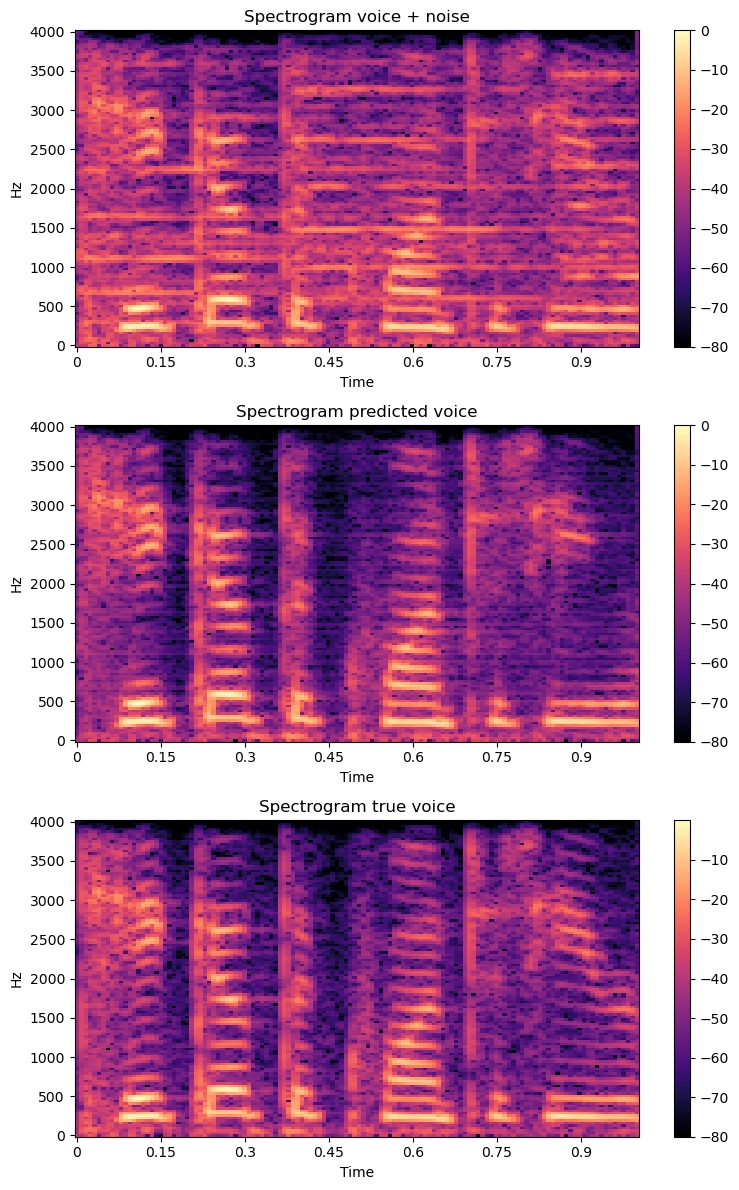

In [28]:
m_amp_db_noisy_voice,  m_pha_noisy_voice =  numpy_audio_to_matrix_spectrogram (noisy_voice_bells.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

m_amp_db_voice_pred,  m_pha_voice_pred =  numpy_audio_to_matrix_spectrogram (voice_pred_bells.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

m_amp_db_voice_true,  m_pha_voice_true =  numpy_audio_to_matrix_spectrogram (voice_bells.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

make_3plots_spec_voice_noise(m_amp_db_noisy_voice[0,:,:],m_amp_db_voice_pred[0,:,:],m_amp_db_voice_true[0,:,:],sample_rate, hop_length_fft)

In [29]:
m_amp_db_voice_true.shape

(1, 128, 128)

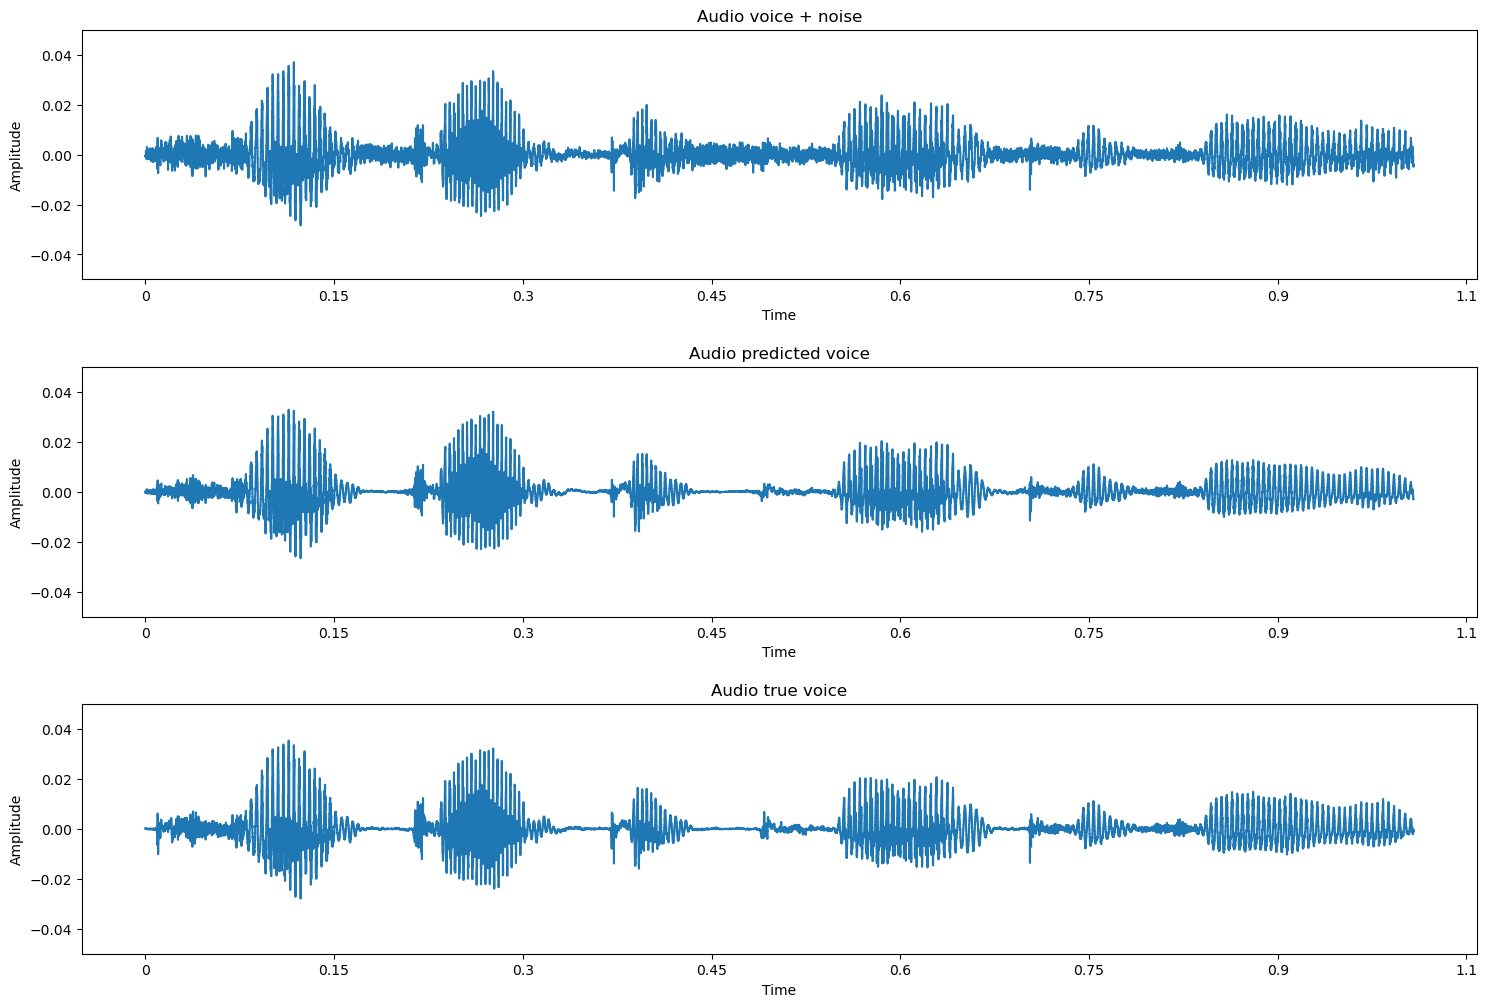

In [30]:
make_3plots_timeseries_voice_noise(noisy_voice_bells,voice_pred_bells,voice_bells, sample_rate)

### Vaccum cleaner sound

In [31]:
list_files = ['noisy_voice_vaccum35.wav','voice_pred_vaccum35.wav','voice_vaccum35.wav']

In [32]:
# Noisy speech
noisy_voice_vaccum, sr = librosa.load(os.path.join(validation_folder_ex,list_files[0]), sr=sample_rate)
Audio(noisy_voice_vaccum, rate=8000)

In [33]:
# Denoised speech
voice_pred_vaccum, sr = librosa.load(os.path.join(validation_folder_ex,list_files[1]), sr=sample_rate)
Audio(voice_pred_vaccum, rate=8000)

In [34]:
# True clean speech
voice_vaccum, sr = librosa.load(os.path.join(validation_folder_ex,list_files[2]), sr=sample_rate)
Audio(voice_vaccum, rate=8000)

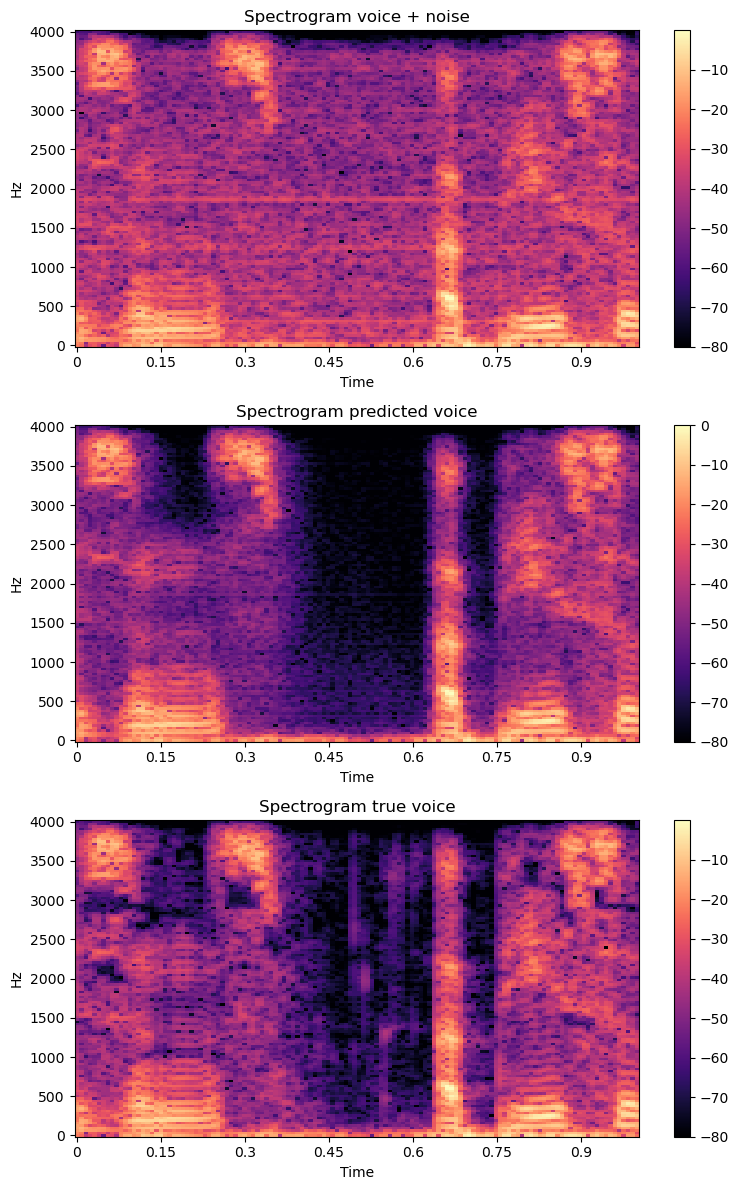

In [35]:
m_amp_db_noisy_voice,  m_pha_noisy_voice =  numpy_audio_to_matrix_spectrogram (noisy_voice_vaccum.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

m_amp_db_voice_pred,  m_pha_voice_pred =  numpy_audio_to_matrix_spectrogram (voice_pred_vaccum.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

m_amp_db_voice_true,  m_pha_voice_true =  numpy_audio_to_matrix_spectrogram (voice_vaccum.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

make_3plots_spec_voice_noise(m_amp_db_noisy_voice[0,:,:],m_amp_db_voice_pred[0,:,:],m_amp_db_voice_true[0,:,:],sample_rate, hop_length_fft)

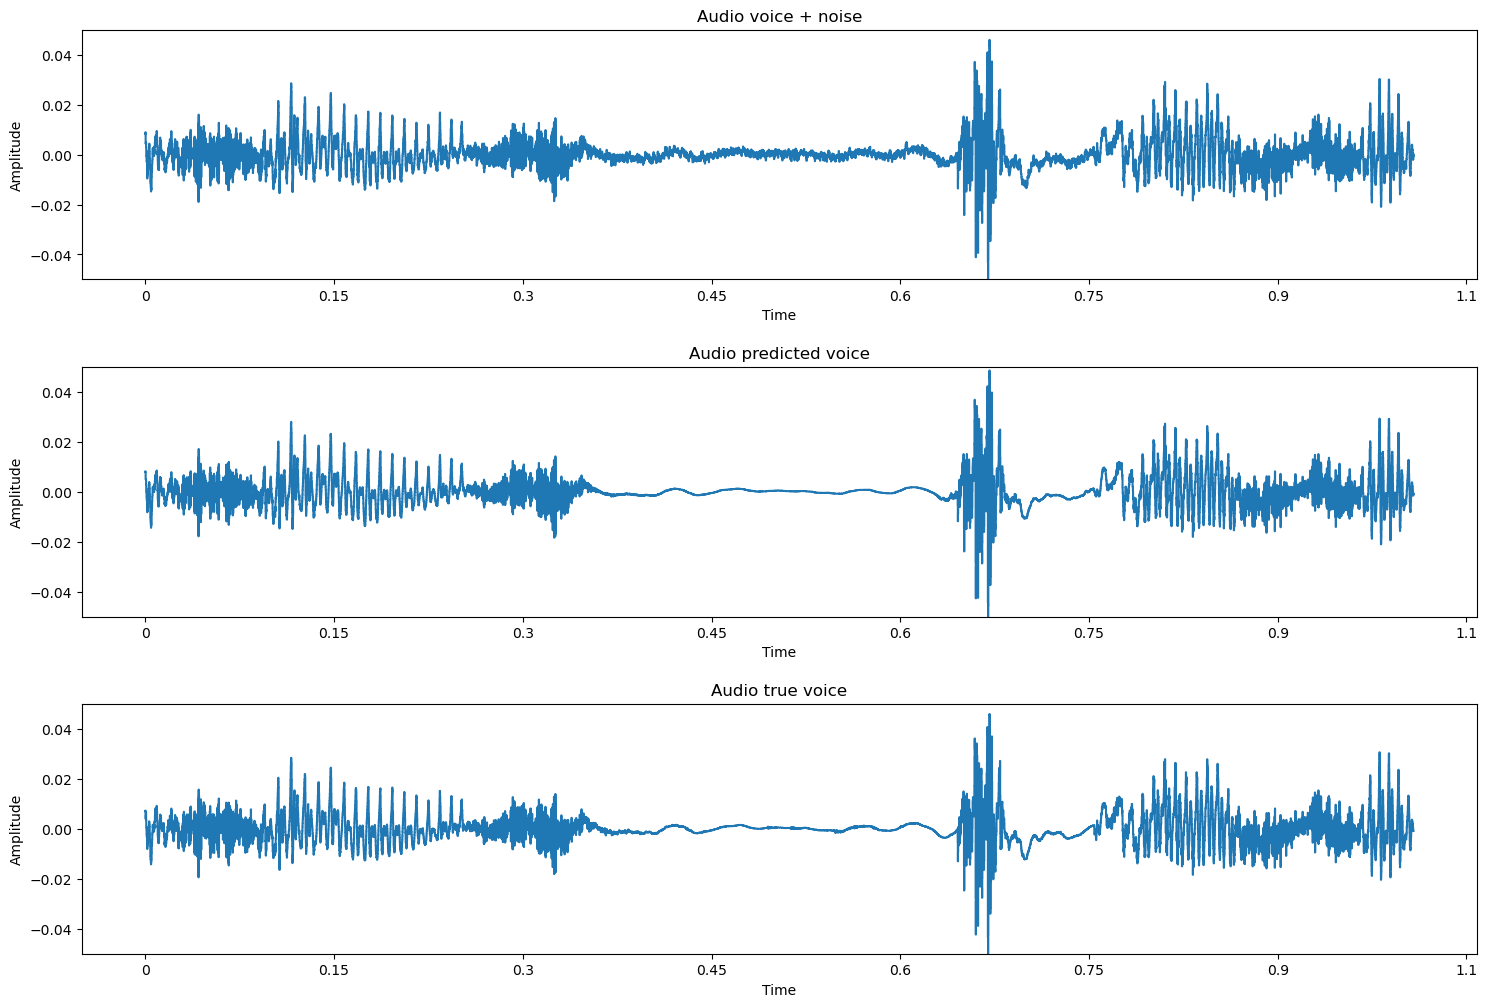

In [36]:
make_3plots_timeseries_voice_noise(noisy_voice_vaccum,voice_pred_vaccum,voice_vaccum, sample_rate)

### Alarm sound

In [37]:
list_files = ['noisy_voice_alarm39.wav','voice_pred_alarm39.wav','voice_alarm39.wav']

In [38]:
# Noisy speech
noisy_voice_alarm, sr = librosa.load(os.path.join(validation_folder_ex,list_files[0]), sr=sample_rate)
Audio(noisy_voice_alarm, rate=8000)

In [39]:
# Denoised speech
voice_pred_alarm, sr = librosa.load(os.path.join(validation_folder_ex,list_files[1]), sr=sample_rate)
Audio(voice_pred_alarm, rate=8000)

In [40]:
# True clean speech
voice_alarm, sr = librosa.load(os.path.join(validation_folder_ex,list_files[2]), sr=sample_rate)
Audio(voice_alarm, rate=8000)

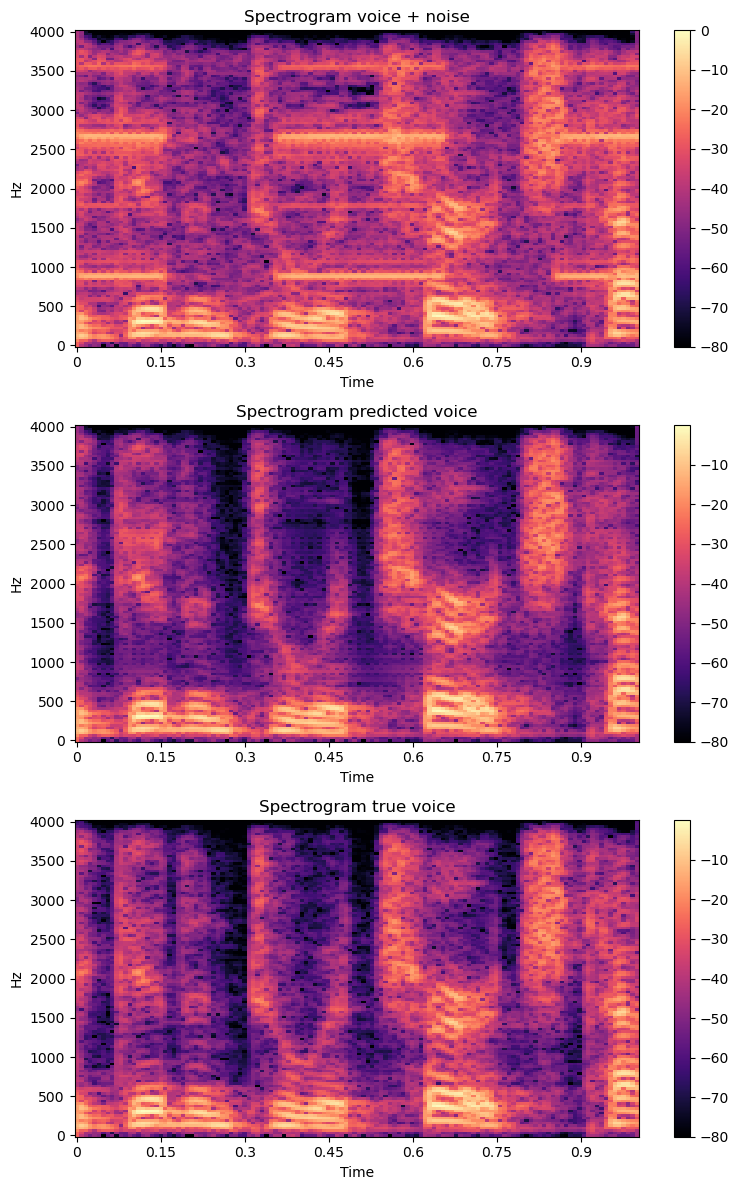

In [41]:
m_amp_db_noisy_voice,  m_pha_noisy_voice =  numpy_audio_to_matrix_spectrogram (noisy_voice_alarm.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

m_amp_db_voice_pred,  m_pha_voice_pred =  numpy_audio_to_matrix_spectrogram (voice_pred_alarm.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

m_amp_db_voice_true,  m_pha_voice_true =  numpy_audio_to_matrix_spectrogram (voice_alarm.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

make_3plots_spec_voice_noise(m_amp_db_noisy_voice[0,:,:],m_amp_db_voice_pred[0,:,:],m_amp_db_voice_true[0,:,:],sample_rate, hop_length_fft)

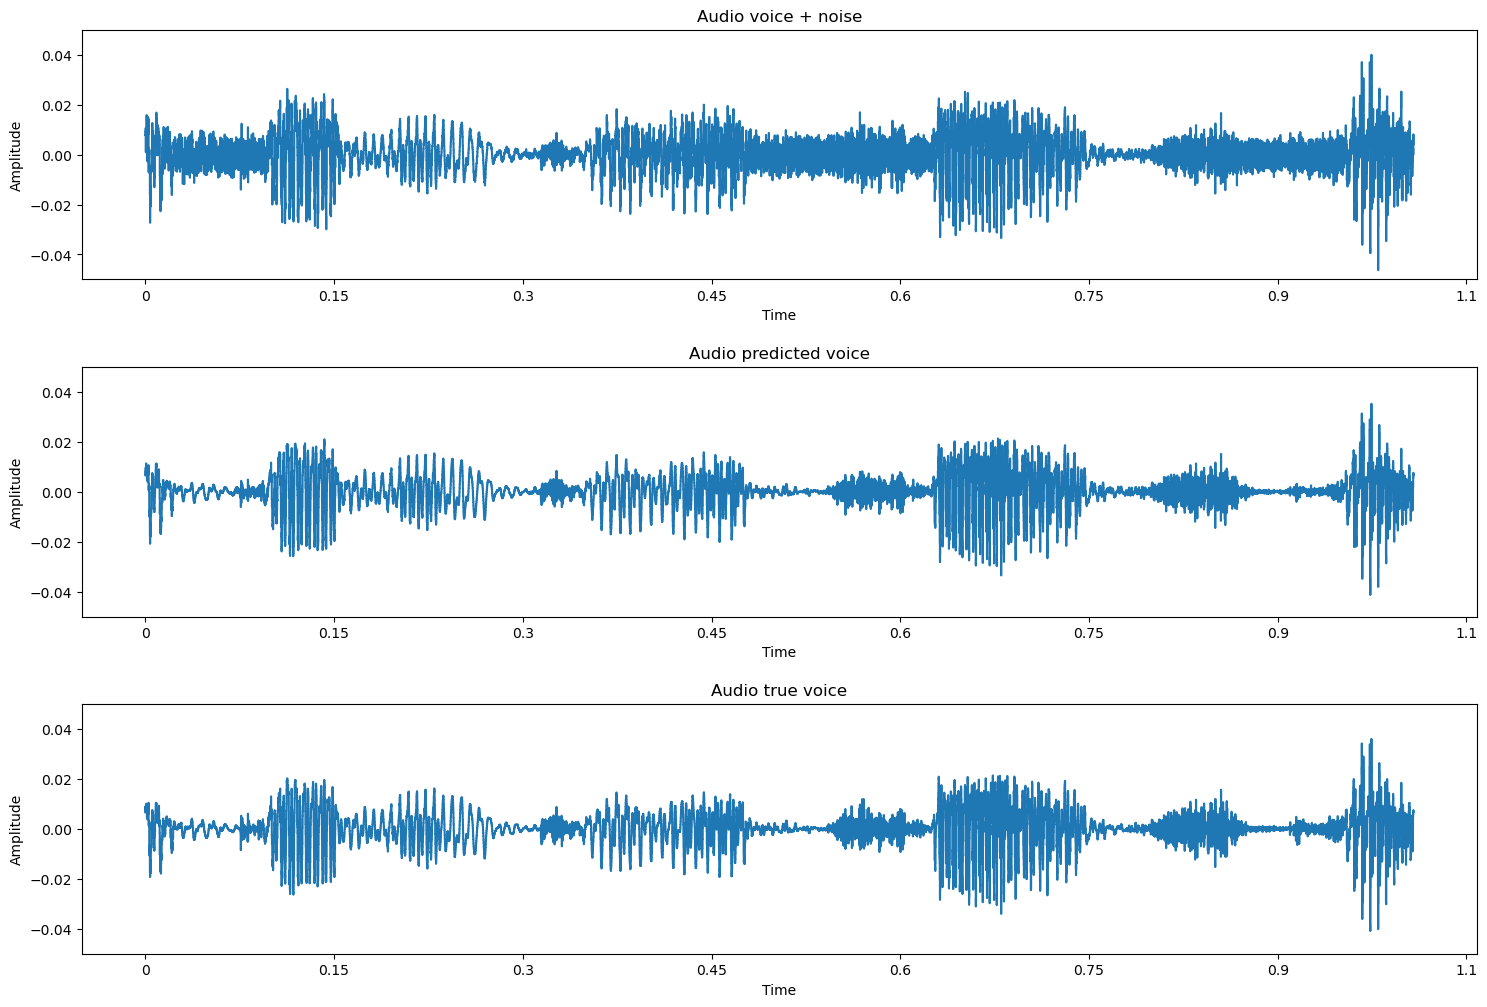

In [42]:
make_3plots_timeseries_voice_noise(noisy_voice_alarm,voice_pred_alarm,voice_alarm, sample_rate)

### Insect sound

In [43]:
list_files = ['noisy_voice_insect41.wav','voice_pred_insect41.wav','voice_insect41.wav']

In [44]:
# Noisy speech
noisy_voice_insect, sr = librosa.load(os.path.join(validation_folder_ex,list_files[0]), sr=sample_rate)
Audio(noisy_voice_insect, rate=8000)

In [45]:
# Denoised speech
voice_pred_insect, sr = librosa.load(os.path.join(validation_folder_ex,list_files[1]), sr=sample_rate)
Audio(voice_pred_insect, rate=8000)

In [46]:
# True clean speech
voice_insect, sr = librosa.load(os.path.join(validation_folder_ex,list_files[2]), sr=sample_rate)
Audio(voice_insect, rate=8000)

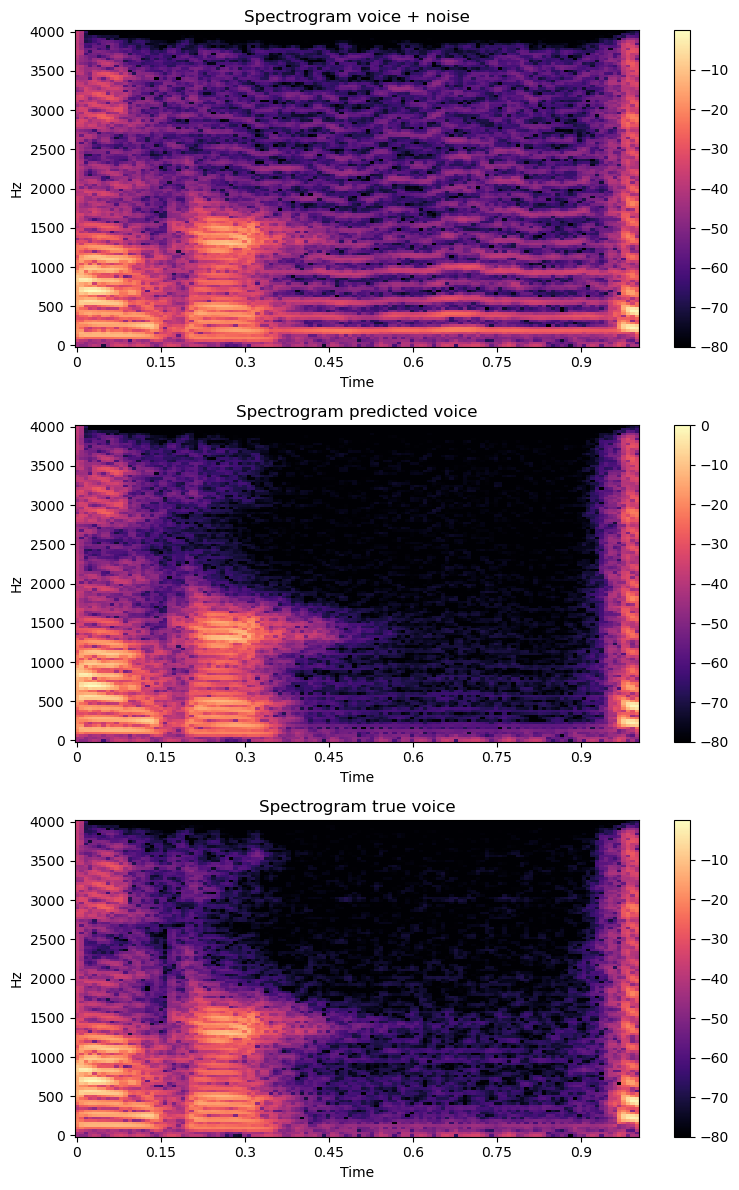

In [47]:
m_amp_db_noisy_voice,  m_pha_noisy_voice =  numpy_audio_to_matrix_spectrogram (noisy_voice_insect.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

m_amp_db_voice_pred,  m_pha_voice_pred =  numpy_audio_to_matrix_spectrogram (voice_pred_insect.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

m_amp_db_voice_true,  m_pha_voice_true =  numpy_audio_to_matrix_spectrogram (voice_insect.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

make_3plots_spec_voice_noise(m_amp_db_noisy_voice[0,:,:],m_amp_db_voice_pred[0,:,:],m_amp_db_voice_true[0,:,:],sample_rate, hop_length_fft)

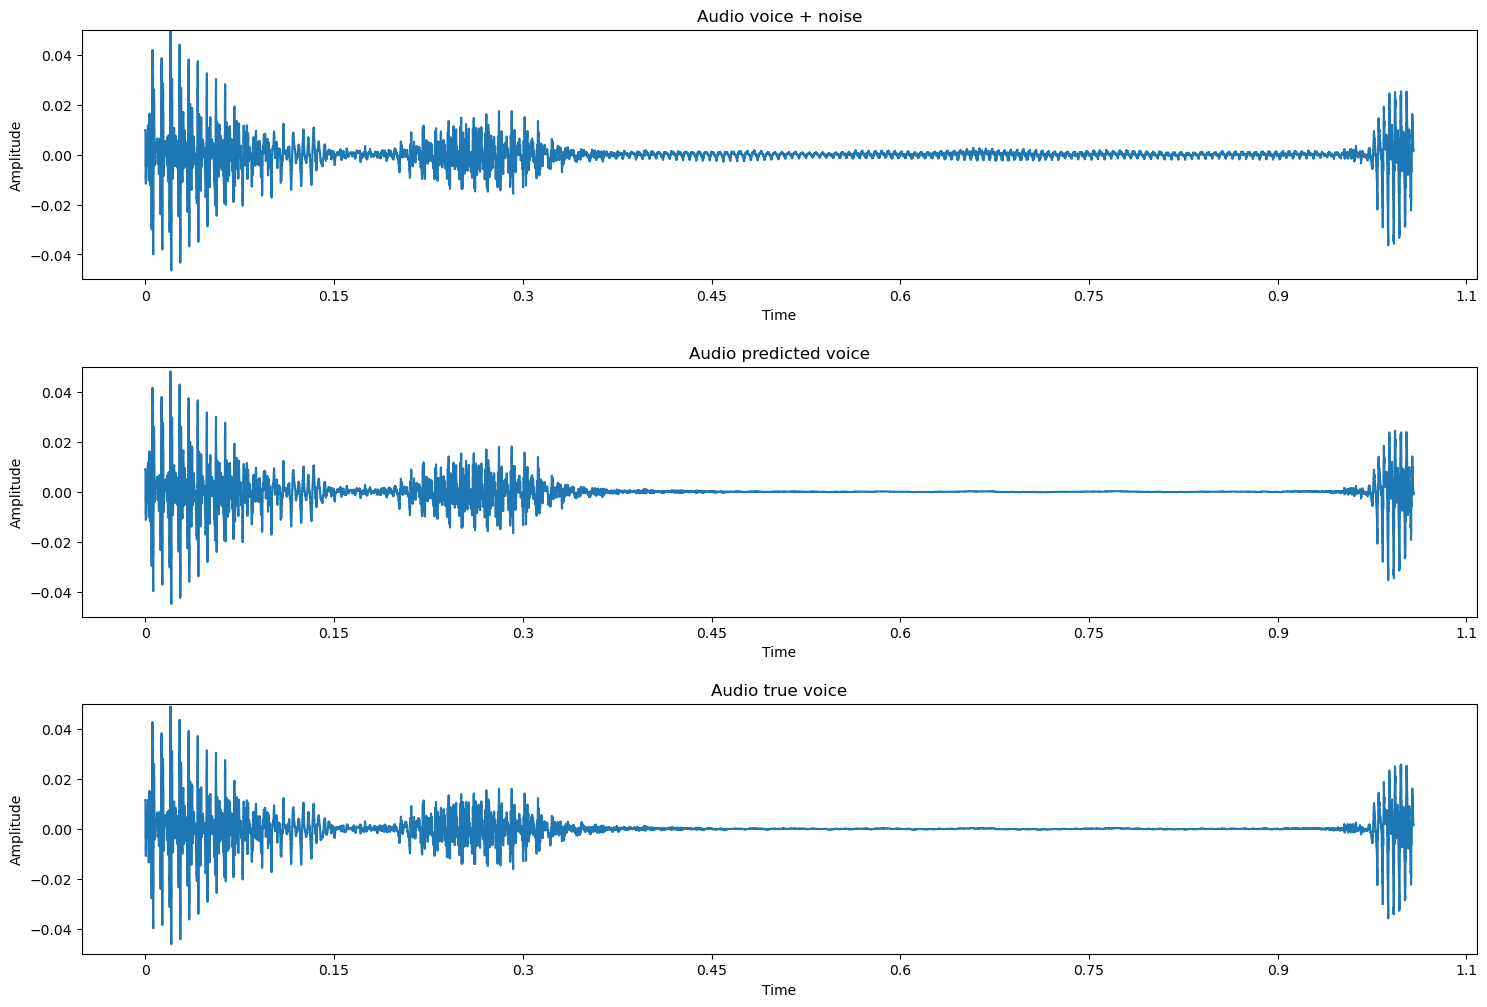

In [48]:
make_3plots_timeseries_voice_noise(noisy_voice_insect, voice_pred_insect, voice_insect, sample_rate)

### Some more predictions

In [49]:
# Example 1

# Noisy speech
noisy_voice_ex1, sr = librosa.load('./demo_data/test/noisy_voice_long_t1.wav', sr=sample_rate)
display(Audio(noisy_voice_ex1, rate=8000))

# Denoised speech
voice_ex1, sr = librosa.load('./demo_data/save_predictions/denoise_t1.wav', sr=sample_rate)
display(Audio(voice_ex1, rate=8000))

In [50]:
# Example 2

# Noisy speech
noisy_voice_ex1, sr = librosa.load('./demo_data/test/noisy_voice_long_t2.wav', sr=sample_rate)
display(Audio(noisy_voice_ex1, rate=8000))

# Denoised speech
voice_ex1, sr = librosa.load('./demo_data/save_predictions/denoise_t2.wav', sr=sample_rate)
display(Audio(voice_ex1, rate=8000))